# Team 20 - EDA Visualizations
## 6m Data 
**Bureau of Transportation Statistics:**   
https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236   
https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations

In [0]:
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType
from pyspark.sql import SQLContext
from pyspark.ml.feature import PCA, RFormula
from pyspark.ml.linalg import Vectors
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.util import MLUtils
sqlContext = SQLContext(sc)

### Data Processing

**Helper Functions**

In [0]:
## helper function to count number of missing values in each column
def count_missings(spark_df,sort=True):
    """
    Counts number of nulls and nans in each column
    """
    df = spark_df.select([f.count(f.when(f.isnull(c) | f.isnan(c), c)).alias(c) for c in spark_df.columns]).toPandas()
    if len(df) == 0:
        print("There are no any missing values!")
        return None
    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)
    return df
  
## helper funciton to run for the weather variables that need to be split into separate columns
def column_split(variables, data):
  for v in variables:
    split = f.split(data[v],',')
    for i in range(len(data.select(split).first()[0])):
      data = data.withColumn(v+'_'+str(i), split.getItem(i).cast(IntegerType()))
  data = data.drop(*variables)
  return data

#plot line charts for temporal variables
def plot_lines(variable, ax = plt):
  m_dd = air.groupby([variable,'ORIGIN']).agg({'DEP_DELAY':'mean'}).reset_index()
  for o in m_dd['ORIGIN'].unique():
    ax.plot(variable,'DEP_DELAY', data = m_dd[m_dd.ORIGIN == o])
  ax.legend(labels=m_dd['ORIGIN'].unique())
  ax.set_xlabel(variable)
  ax.set_ylabel('Avg DEP_DELAY')

In [0]:
airlines = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data_6m/")

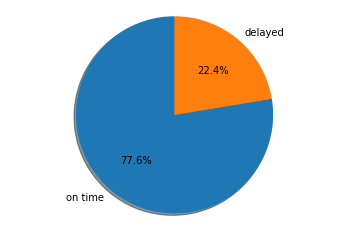

In [0]:
# number of flights for each class
class_0 = airlines.filter(f.col('DEP_DEL15') == 0) \
                    .count()
class_1 = airlines.filter(f.col('DEP_DEL15') == 1) \
                    .count()

# fraction of observations that were of each class
labels = ['on time', 'delayed']
sizes = [class_0, class_1]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [0]:
air = airlines.toPandas()

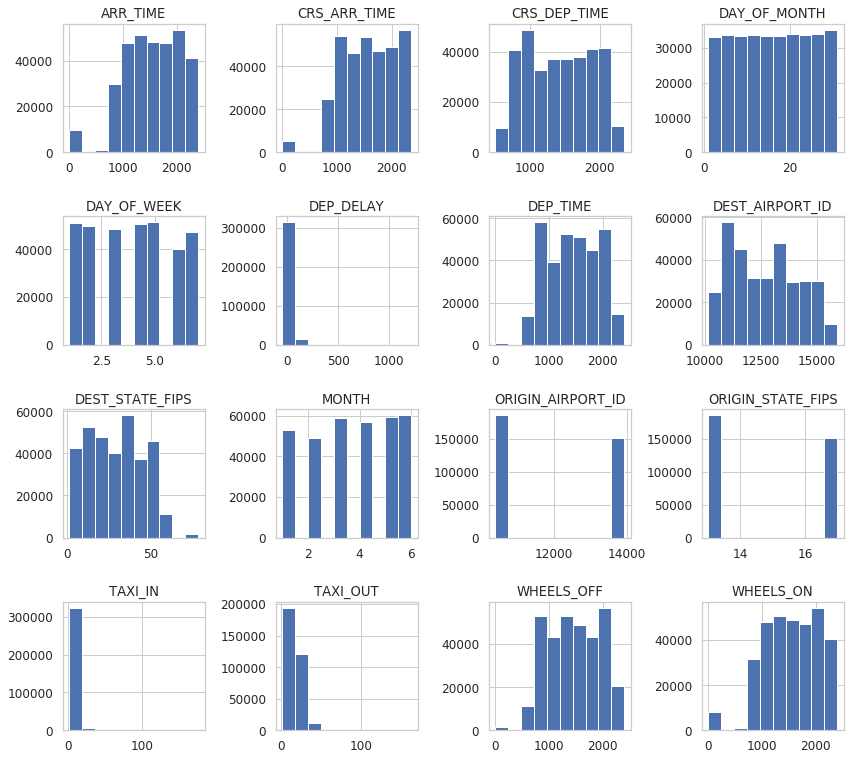

In [0]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

numerical = ['MONTH','DAY_OF_MONTH','DAY_OF_WEEK','ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID','ORIGIN_STATE_FIPS','DEST_STATE_FIPS','CRS_DEP_TIME','DEP_TIME','TAXI_OUT','WHEELS_OFF','WHEELS_ON','TAXI_IN','CRS_ARR_TIME','ARR_TIME','DEP_DELAY']

air[numerical].hist(layout=(4,4), figsize=(14,13))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

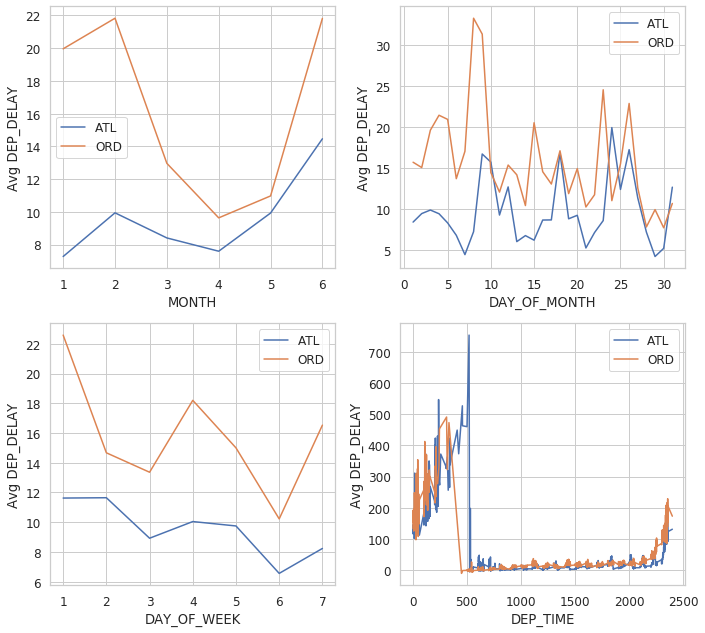

In [0]:
temporal = ['MONTH','DAY_OF_MONTH','DAY_OF_WEEK','DEP_TIME']

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,9))

for v,a in zip(temporal, [ax1,ax2,ax3,ax4]):
  plot_lines(v, a)
  
fig.tight_layout()

In [0]:
awsc_table = spark.read.option("header", "true").parquet(f"dbfs:/tmp/out/final_6m1.parquet")
awsc = awsc_table.toPandas()

Out[29]:

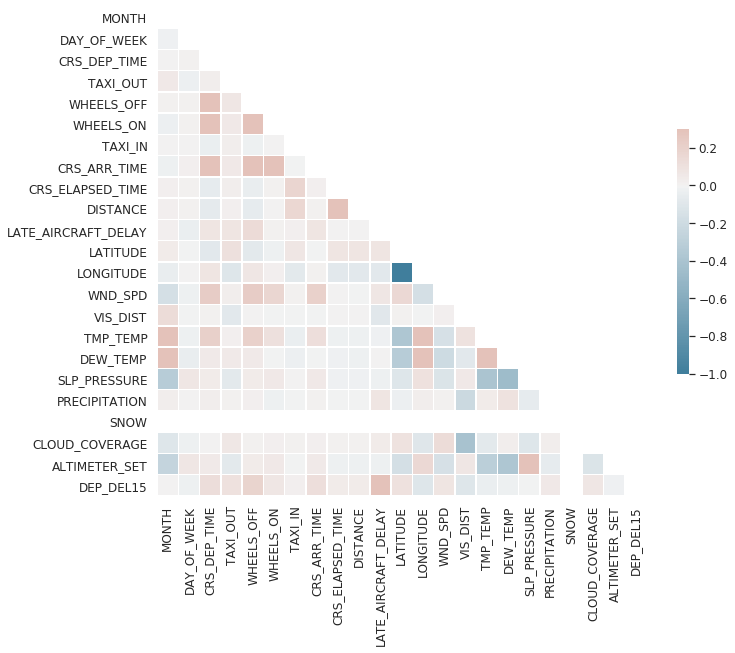

<matplotlib.axes._subplots.AxesSubplot at 0x7fbae33b6710>

In [0]:
# move DEP_15 to the end
temp = awsc['DEP_DEL15']
awsc = awsc.drop('DEP_DEL15', axis=1)
awsc['DEP_DEL15'] = temp

# calculate correlation 
corr = awsc.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})